# Setup 

In [ ]:
%%capture
!pip install watermark

In [ ]:
%load_ext watermark
%watermark -p tensorflow,numpy -m

tensorflow 1.12.0
numpy 1.14.6

compiler   : GCC 8.2.0
system     : Linux
release    : 4.14.65+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import sys
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.python.framework import ops
from tensorflow.python.ops import clip_ops
from tensorflow.contrib.rnn import LSTMCell
#from tensorflow.contrib.rnn.python.ops import core_rnn
from tensorflow.python.ops import rnn
import matplotlib.pylab as plt
import math
from scipy.stats import logistic
import pandas as pd
from pandas import read_csv
from datetime import datetime
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
%matplotlib inline

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout
from keras.layers import LSTM, CuDNNLSTM
from keras.datasets import imdb

from distutils.version import LooseVersion as LV
from keras import __version__
from keras import backend as K

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

print('Using Keras version:', __version__, 'backend:', K.backend())
assert(LV(__version__) >= LV("2.0.0"))

Using TensorFlow backend.


Using Keras version: 2.2.4 backend: tensorflow


/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Functions Definition


In [ ]:
def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    """convert series to supervised learning"""
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    df_columns = columns
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('{}(t-{})'.format(df_columns[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('{}(t)'.format(df_columns[j])) for j in range(n_vars)]
        else:
            names += [('{}(t+{})'.format(df_columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def sample_batch(X_train, Y_train, X_test, Y_test, batch_size):
    global BATCH_START
    """ Function to sample a batch for training"""
    X_train_batch = X_train[BATCH_START:(BATCH_START + batch_size)]
    y_train_batch = Y_train[BATCH_START:(BATCH_START + batch_size)]
    X_test_batch = X_test[BATCH_START:(BATCH_START + batch_size)]
    y_test_batch = Y_test[BATCH_START:(BATCH_START + batch_size)]
    BATCH_START += batch_size
    return X_train_batch, y_train_batch, X_test_batch, y_test_batch

def get_server_data(data_all, server_id):
    _columns_all = data_all.columns
    key_to_match = 'server_{}_'.format(server_id)
    _cols = [_col for _col in _columns_all if key_to_match in _col]
    result = data_all[_cols].copy()
    _cols_mapper = {}
    for _col in _cols:
        _cols_mapper[_col] = _col.replace('server_{}_'.format(server_id), '')
    result = result.rename(index=str, columns=_cols_mapper)
    result['label'] = ['server_{}'.format(server_id)] * result.shape[0]
    return result

# Load Data


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
dataset = pd.read_csv('/content/gdrive/My Drive/test.csv', sep='\t', index_col=0)

In [ ]:
dataset.head(5)

,t,server_1_cpu,server_1_apache,server_1_n_packet,server_1_n_byte,server_1_n_flow_new,server_1_n_flow_end,server_1_n_first_ack,server_1_n_data_ack,server_1_d_n_packet,...,server_12_cpu_sm_2,server_12_cpu_sm_3,server_12_cpu_sm_4,server_12_cpu_sm_5,server_12_cpu_sm_10,server_12_cpu_sm_15,server_12_cpu_sm_20,server_12_cpu_sm_25,server_12_cpu_sm_50,server_12_cpu_sm_100
0,9.12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,7.0
1,9.13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,7.0
2,9.14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,7.0
3,9.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,7.0
4,9.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,7.0,7.0


In [ ]:
# init and load server data
FEATURE_FIELDS = [ 'n_packet', 'n_byte', 'n_flow_new', 'n_flow_end', 'n_data_ack',
                   'iat_avg', 'iat_std', 'iat_max', 'iat_min', 
                   'n_retransmission', 'n_404', 
                   'iat_h1', 'iat_h2', 'iat_h3', 'iat_h4', 'iat_h5', 'iat_h6', 'iat_h7', 'iat_h8', 'iat_h9', 
                   'data_size_h1', 'data_size_h2', 'data_size_h3', 'data_size_h4', 'data_size_h5', 'data_size_h6', 'data_size_h7', 'data_size_h8']
server_id = 1
n_thread = 0
server_data = get_server_data(dataset, server_id)
server_data['is_blank'] = [0 if n == 0 else 1 for n in server_data['n_packet']]
N_THREAD = []
for i in range(server_data.shape[0]):
    n_thread = n_thread + server_data['n_flow_new'].iloc[i] - server_data['n_flow_end'].iloc[i]
    N_THREAD.append(n_thread)
server_data['n_thread'] = N_THREAD

In [ ]:
# config
server_id = 1  # server to learn
seq_len = 50  # sequence length (time steps)
sm_level = -1  # cpu smoothness level
SMOOTHNESS = [1, 2, 3, 4, 5, 10, 15, 20, 25, 50, 100]
cpu_smoothness = SMOOTHNESS[sm_level]
GT_FIELDS = ['cpu_sm_{}'.format(cpu_smoothness), 'apache']
DATA_FIELDS = GT_FIELDS + FEATURE_FIELDS
print('Process Data: server_id = {}, seq_len = {}, cpu_smoothness = {}'.format(server_id, seq_len, cpu_smoothness))

Process Data: server_id = 1, seq_len = 50, cpu_smoothness = 100


In [ ]:
# normalize and scale dataset

feature_without_gradient = [feature for feature in FEATURE_FIELDS if 'd_' not in feature]
feature_gradient = [feature for feature in FEATURE_FIELDS if 'd_' in feature]

server_data = server_data[DATA_FIELDS].copy()
server_data.head()
scaler = MinMaxScaler(feature_range=(0, 1))
server_data[feature_without_gradient] = scaler.fit_transform(server_data[feature_without_gradient])
server_data[GT_FIELDS] = scaler.fit_transform(server_data[GT_FIELDS])

gradient_max = np.max(np.abs(server_data[feature_gradient]))
for i in gradient_max.keys():
    server_data[i] = server_data[i] / gradient_max[i]

In [ ]:
# frame as supervised learning
reframed = series_to_supervised(server_data, DATA_FIELDS, seq_len, 1)
# drop columns we don't want to predict
reframed.head()

,cpu_sm_100(t-50),apache(t-50),n_packet(t-50),n_byte(t-50),n_flow_new(t-50),n_flow_end(t-50),n_data_ack(t-50),iat_avg(t-50),iat_std(t-50),iat_max(t-50),...,iat_h8(t),iat_h9(t),data_size_h1(t),data_size_h2(t),data_size_h3(t),data_size_h4(t),data_size_h5(t),data_size_h6(t),data_size_h7(t),data_size_h8(t)
50,0.026923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51,0.038462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52,0.050000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53,0.061538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54,0.069231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# drop irrelavant columns
cols_to_drop = reframed.columns[[i * len(DATA_FIELDS) for i in range(0, seq_len)] 
                                + [i * len(DATA_FIELDS) + 1 for i in range(0, seq_len)] 
                                + [i for i in range(reframed.shape[1] - len(FEATURE_FIELDS), reframed.shape[1])]]
reframed.drop(cols_to_drop, axis=1, inplace=True)
reframed.head()

,n_packet(t-50),n_byte(t-50),n_flow_new(t-50),n_flow_end(t-50),n_data_ack(t-50),iat_avg(t-50),iat_std(t-50),iat_max(t-50),iat_min(t-50),n_retransmission(t-50),...,data_size_h1(t-1),data_size_h2(t-1),data_size_h3(t-1),data_size_h4(t-1),data_size_h5(t-1),data_size_h6(t-1),data_size_h7(t-1),data_size_h8(t-1),cpu_sm_100(t),apache(t)
50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.553846,0.2
51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.553846,0.2
52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.553846,0.2
53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.553846,0.4
54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.553846,0.2


In [ ]:
# Get X and Y
X, Y = reframed.iloc[:, :-2], reframed.iloc[:, -2:]

In [ ]:
dt = 0.2
t_step = int(dt / 0.01)
gt_id = 0

train_X, train_y = X.iloc[::t_step, :], Y.iloc[::t_step, :]
test_X, test_y = X.iloc[int(t_step / 2)::t_step, :], Y.iloc[int(t_step / 2)::t_step, :]

train_y = train_y[GT_FIELDS[gt_id] + '(t)']
test_y = test_y[GT_FIELDS[gt_id] + '(t)']

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.values.reshape((train_X.shape[0], seq_len, int(train_X.shape[1] / seq_len)))
test_X = test_X.values.reshape((test_X.shape[0], seq_len, int(test_X.shape[1] / seq_len)))

# reshape output to be 2D [samples, 1]
train_y = train_y.values.reshape((-1, 1))
test_y = test_y.values.reshape((-1, 1))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(248, 50, 28) (248, 1) (247, 50, 28) (247, 1)


In [ ]:
# model parameters:
embedding_dims = 10
lstm_units = 32

print('Build model...')
model = Sequential()

# model.add(Embedding(28,
#                     embedding_dims,
#                     input_length=50))
# model.add(Dropout(0.2))

model.add(CuDNNLSTM(lstm_units, input_shape=(50, 28), return_sequences=True))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(lstm_units))
# or if running on a GPU:

# To stack multiple RNN layers, all RNN layers except the last one need
# to have "return_sequences=True".  An example of using two RNN layers:
#model.add(LSTM(lstm_units, return_sequences=True))
#model.add(LSTM(lstm_units))

model.add(Dense(1))


# try using different optimizers and different optimizer configs
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'mape', 'cosine'])

print(model.summary())

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 50, 32)            7936      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 32)            0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 32)                8448      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 16,417
Trainable params: 16,417
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
%%time
epochs = 5
validation_split = 0.2

history = model.fit(train_X, train_y, batch_size=4,
          epochs=epochs, 
          validation_split=validation_split)

Train on 198 samples, validate on 50 samples
Epoch 1/5
198/198 [==============================] - 5s 27ms/step - loss: 0.0742 - mean_squared_error: 0.0742 - mean_absolute_error: 0.2149 - mean_absolute_percentage_error: 60.9461 - cosine_proximity: -0.9394 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1010 - val_mean_absolute_percentage_error: 19.5972 - val_cosine_proximity: -1.0000
Epoch 2/5
198/198 [==============================] - 1s 6ms/step - loss: 0.0327 - mean_squared_error: 0.0327 - mean_absolute_error: 0.1474 - mean_absolute_percentage_error: 44.1276 - cosine_proximity: -1.0000 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1086 - val_mean_absolute_percentage_error: 19.7636 - val_cosine_proximity: -1.0000
Epoch 3/5
198/198 [==============================] - 1s 6ms/step - loss: 0.0317 - mean_squared_error: 0.0317 - mean_absolute_error: 0.1425 - mean_absolute_percentage_error: 44.8555 - cosine_proximity: -1.0000

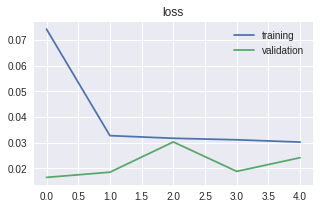

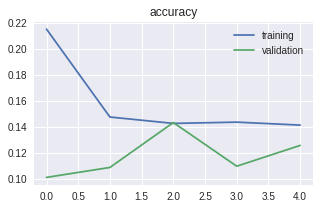

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'], label='training')
plt.plot(history.epoch,history.history['val_loss'], label='validation')
plt.title('loss')
plt.legend(loc='best')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['mean_absolute_error'], label='training')
plt.plot(history.epoch,history.history['val_mean_absolute_error'], label='validation')
plt.title('accuracy')
plt.legend(loc='best');

In [ ]:
scores = model.evaluate(test_X, test_y, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

mean_squared_error: 3.07%
